Author Linkedin: https://www.linkedin.com/in/hernane-braga-pereira/

This notebook was provided by this Kaggle dataset on loan default predicions: https://www.kaggle.com/subhamjain/loan-prediction-based-on-customer-behavior

---

# Loan Prediction Based on Customer Behavior
_Predict possible client defaults for Loans Product_

**Main question**: _Is it possible to determine which consumer may default on a loan?_ 



**_Answer:_** Yes. With a random forest model that achieves: ROC AUC = 0.94 and PR AUC = 0.54

---
To understand how we got these results, we'll dive into three main topics:

1. Creating a baseline model;
2. Understanding our data;
3. Improving our solution.



---
**Loading libraries and data**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score # AUC ROC
from sklearn.metrics import average_precision_score # AUC PRC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Setting data path and filenames
data_path = '../data/'
filename_train = 'Training Data.csv'
filename_test = 'Test Data.csv'
img_out_path = '../out/img/' #ouput path

# Loading data
df_train_org = pd.read_csv(data_path+filename_train)
df_test_org = pd.read_csv(data_path+filename_test)

# Wrangled dataframe
df_train_wrg = df_train_org.copy()
df_test_wrg = df_test_org.copy()


In [3]:
print('Train:', df_train_org.shape)
print('Test:', df_test_org.shape)

Train: (252000, 13)
Test: (28000, 12)


**Operations proportions between classes**
- Risk: 12.3%
- No-Risk: 87.7%

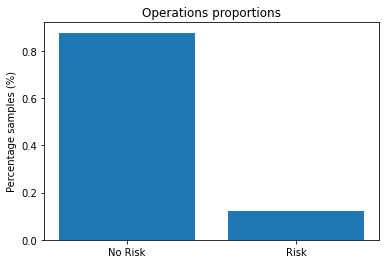

In [4]:
hist_risk = df_train_org['Risk_Flag'].value_counts(normalize=True) 
plt.bar(x=hist_risk.index, height=hist_risk)
plt.xticks([0,1],['No Risk', 'Risk'])
plt.ylabel('Percentage samples (%)')
plt.title('Operations proportions')
plt.savefig(img_out_path+'hist_operations_proportions')

--- 
# Creating a baseline model

1. Sanity check on data;
2. Basic data cleaning;
3. Modeling the problem.


At the end of this section, our baseline model achieved those metrics with a decision tree algorithm:
- AUC ROC -- 0.84
- AUC PRC -- 0.4

## Sanity check on data

1. There are different data at training and test datasets?  
2. What are the data types on the training dataset?
3. What is the percentage of missing values?

### **There are different data at training and test datasets?**  

Not in the input data, only at the target variable.

- There's no difference in data that may be used as features for the model;
- The Id (training) and ID (test) columns have different names;
- We don't have the answer (target variable) for the test dataset.

In [5]:
def check_train_test_data(df_train: pd.DataFrame, df_test:pd.DataFrame):
    """Print the difference between each dataset columns"""
    col_names_train = set(df_train.columns)
    col_names_test = set(df_test.columns)

    diff_train_test = col_names_train.difference(col_names_test)
    diff_test_train = col_names_test.difference(col_names_train)

    msg_text = 'Columns on training dataset NOT available on test dataset:\n'
    print(msg_text, diff_train_test)

    msg_text = '\nColumns on test dataset NOT available on training dataset:\n'
    print(msg_text, diff_test_train)

In [6]:
check_train_test_data(df_train_org, df_test_org)

Columns on training dataset NOT available on test dataset:
 {'Risk_Flag', 'Id'}

Columns on test dataset NOT available on training dataset:
 {'ID'}


### **What are the data types on the training datasets?**

- Numeric and categorical
- Categorical data that can be cast to numerical due to a low number of categories:
    - Married/Single: married or single;
    - Car_Ownership: yes, no;
    - House ownership: rented, owned, norent_nown.


In [7]:
def check_dtypes(df: pd.DataFrame, n_samples=5):
    """
    Print a summary of dataframe datatype and return object
    and no-object colum datatype names
    """
    df_dtypes = df.dtypes
    
    dtype_resume = df_dtypes.value_counts()
    print('Data types summary:\n', dtype_resume)

    mask_obj = (df_dtypes == 'object')
    obj_cols = df_dtypes[mask_obj]
    non_obj_cols = df_dtypes[~mask_obj]
    
    display(df.sample(n_samples))
    print('\nPossible categorical columns (object):\n', obj_cols)    
    print('\n\nNumerical columns:\n', non_obj_cols)
    
    return obj_cols, non_obj_cols

In [8]:
obj_cols, non_obj_cols = check_dtypes(df_train_org)

Data types summary:
 int64     7
object    6
dtype: int64


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
68421,68422,6973369,68,20,single,rented,no,Physician,Raebareli,Uttar_Pradesh,11,13,1
147730,147731,5783146,51,18,single,rented,no,Psychologist,Chittoor[28],Andhra_Pradesh,7,12,0
77526,77527,2670187,23,8,single,rented,no,Politician,Nanded,Maharashtra,8,10,0
11382,11383,853211,40,5,single,rented,no,Civil_servant,Tirunelveli,Tamil_Nadu,5,10,0
177291,177292,7764998,33,9,married,rented,yes,Financial_Analyst,Davanagere,Karnataka,7,14,0



Possible categorical columns (object):
 Married/Single     object
House_Ownership    object
Car_Ownership      object
Profession         object
CITY               object
STATE              object
dtype: object


Numerical columns:
 Id                   int64
Income               int64
Age                  int64
Experience           int64
CURRENT_JOB_YRS      int64
CURRENT_HOUSE_YRS    int64
Risk_Flag            int64
dtype: object


In [9]:
def plot_multiple_histogram(df, cols_to_histogram):
    for colname in cols_to_histogram:
        hist_data = df[colname].value_counts(normalize=True)
        plt.title('Histogram: ' + colname)
        plt.barh(y=hist_data.index, width=hist_data*100)
        plt.xlabel('Percentage (%)')
        plt.tight_layout()
        plt.show()

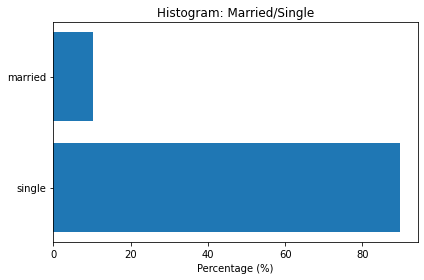

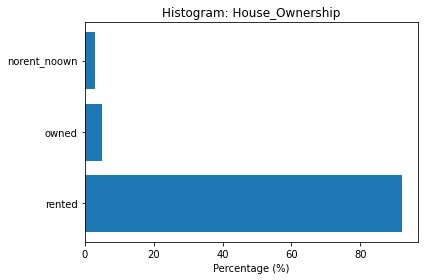

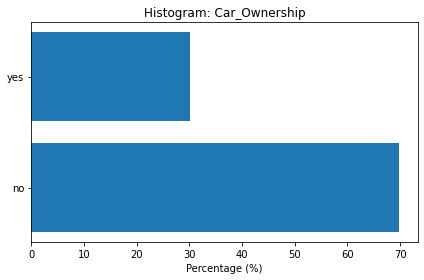

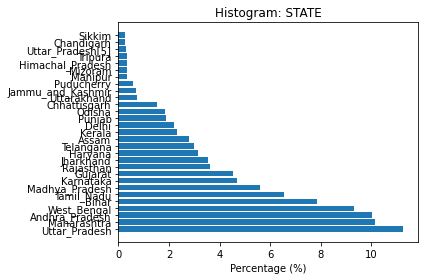

In [10]:
cols_to_histogram = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'STATE']
plot_multiple_histogram(df_train_org, cols_to_histogram)

### **What is the percentage of missing values?** 

None.

In [11]:
def plot_missing_values_sorted(df):
    na_series = (df.isna().sum() / df.shape[0])
    na_series = 100*na_series
    na_series = na_series.sort_values(ascending=False)

    if(na_series.sum() == 0):
        print('No missing values in any columns')
        
    else:
        plt.bar(x=np.arange(len(na_series)), height=na_series)

        plt.ylabel('Percentage of missing values (%)')
        plt.xlabel('Feature n° sorted by missing values')
        plt.tight_layout()
        plt.show()

In [12]:
plot_missing_values_sorted(df_train_org)

No missing values in any columns



---
## Basic data cleaning

1. Dealing with columns properties: drop, change datatype or name;
2. Dealing with missing values.

### Dealing with columns properties: dropping, change names or data types

1. Casting columns to numerical:
    - Married/Single --> Is_Single
    - Car_Ownership --> Has_Car
    
    
2. Drop columns:
   - ID: will not be used for predictions    
   - Married/Single
   - Car_Ownership

**1. Casting columns to numerical**

    - Married/Single --> Is_Single
    - Car_Ownership --> Has_Car

In [13]:
single_transformer = preprocessing.LabelEncoder()
car_owner_transformer = preprocessing.LabelEncoder()

single_transformer.fit(df_train_wrg['Married/Single'])
car_owner_transformer.fit(df_train_wrg['Car_Ownership'])

print('Single classes:', single_transformer.classes_)
print('Has car classes:', car_owner_transformer.classes_)

Single classes: ['married' 'single']
Has car classes: ['no' 'yes']


In [14]:
df_train_wrg['Is_Single'] = single_transformer.transform(df_train_wrg['Married/Single'])
df_train_wrg['Has_Car'] = car_owner_transformer.transform(df_train_wrg['Car_Ownership'])

In [15]:
df_train_wrg.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Is_Single,Has_Car
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,1,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,1,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,0,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,1,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,1,0


**2. Droping columns**
   - ID: will not be used for predictions    
   - Married/Single
   - Car_Ownership

In [16]:
cols_to_drop = ['Married/Single', 'Car_Ownership', 'Id']
df_train_wrg = df_train_wrg.drop(columns=cols_to_drop)

df_train_wrg.head()

,Income,Age,Experience,House_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Is_Single,Has_Car
0,1303834,23,3,rented,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,1,0
1,7574516,40,10,rented,Software_Developer,Parbhani,Maharashtra,9,13,0,1,0
2,3991815,66,4,rented,Technical_writer,Alappuzha,Kerala,4,10,0,0,0
3,6256451,41,2,rented,Software_Developer,Bhubaneswar,Odisha,2,12,1,1,1
4,5768871,47,11,rented,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,1,0


In [17]:
def basic_data_cleaning(df):
    single_transformer = preprocessing.LabelEncoder()
    car_owner_transformer = preprocessing.LabelEncoder()

    single_transformer.fit(df['Married/Single'])
    car_owner_transformer.fit(df['Car_Ownership'])
    
    df['Is_Single'] = single_transformer.transform(df['Married/Single'])
    df['Has_Car'] = car_owner_transformer.transform(df['Car_Ownership'])
    
    cols_to_drop = ['Married/Single', 'Car_Ownership']
    df = df.drop(columns=cols_to_drop)
    
    return df

### Dealing with columns properties: dropping, change names or data types

There are no missing values in this dataset

---
## Modeling the problem
1. Evaluation metric
2. Prepare data for training
3. Create baseline model

### Evaluation metric

For this problem:

- True Positive (TP): our model predicted a high probability of loan default, and it would be a default;
- True Negative (TN): our model predicted that the operation has a low risk and it had a low risk;
- False Positive (FP): our model predicted RISK, and it hasn't happened a loan default;
- False Negative (FN): our model predicted NO RISK, and the operation was RISK <--- **Worst case scenario**.

Since we want to avoid the False Negatives and maximize the True Positive and True Negative, we'll use two main metrics to compare models:

- AUC ROC: area under curve ROC 
- AUC PRC: area under the precision-recall curve

With these metrics, we can compare different classifications thresholds. Along the way, we'll also use the confusion matrix to analyse the results of the prediction with a standard threshold of 0.5

### Prepare data for training

1. Apply a basic data cleaning pipeline;
2. Check class balance;
3. Split data between train and test.

**Basic data cleaning pipeline**

In [18]:
df_train_wrg = df_train_org.copy()
df_test_wrg = df_test_org.copy()

df_train_wrg = basic_data_cleaning(df_train_wrg)
df_train_wrg = df_train_wrg.drop(columns=['Id'])

**Class balance**: unbalanced dataset
- Risk operations - 12.3%
- No risk - 87.7%

Balancing techniques are required like:
- Balance during training;
- Apply undersample techniques like SMOTE.

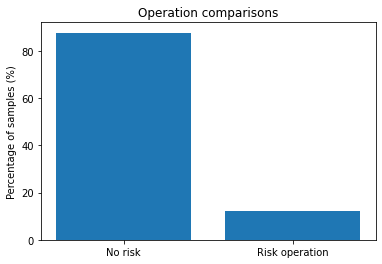

In [19]:
risk_pct = df_train_wrg['Risk_Flag'].value_counts(normalize=True)
risk_pct *= 100

plt.title('Operation comparisons')
plt.bar(x=risk_pct.index, height=risk_pct)
plt.xticks([0, 1],['No risk', 'Risk operation'])
plt.ylabel('Percentage of samples (%)')
plt.show()

**Split between validation, train and test**

- 10% validation: with 12.4% risk (seed=42)
- 20% test: with 12.3% risk       (seed=42)
- 70% training: with 12.2% risk   (seed=42)

Validation data will be used for our final predicitons since we don't have the answer for the 'test' data.

In [20]:
def split_val_train_test(df, col_target, divison_pct=[0.1,0.2], rdn_seed=42):
    """
    Split dataframe into X and Y and 
    then split into validation, train and test
    """
    from sklearn.model_selection import train_test_split
    
    X = df.drop(columns=col_target).copy()
    y = df[col_target].copy().values.ravel()
    
    # Validation dataset
    if(divison_pct[0] > 0):
        X_not_val, X_val, y_not_val, y_val = train_test_split(X, y,
                                                              test_size=divison_pct[0],
                                                              random_state=rdn_seed)
    else:
        X_not_val = X
        y_not_val = y
        X_val = []
        y_val = []
        
    # Train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(X_not_val, y_not_val,
                                                        test_size=divison_pct[1],
                                                        random_state=rdn_seed)
    
    # Return splitted data as dictionary 
    splitted_data = [X_train, X_test, X_val, y_train, y_test, y_val]
    key_names = ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val']
    splitted_data_dict = dict(zip(key_names, splitted_data))
    
    return splitted_data_dict

In [21]:
X_train, X_test, y_train, y_test = [],[],[],[]
col_target = ['Risk_Flag']

splitted_data_dict = split_val_train_test(df_train_wrg, col_target)

# Assigning values
X_train, y_train = splitted_data_dict['X_train'], splitted_data_dict['y_train']
X_test, y_test = splitted_data_dict['X_test'], splitted_data_dict['y_test']
X_val, y_val = splitted_data_dict['X_val'], splitted_data_dict['y_val']

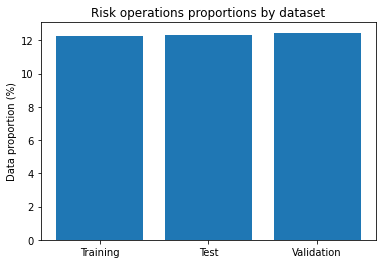

In [22]:

# data prep
val_prop = y_val.sum()/len(y_val) * 100
test_prop = y_test.sum()/len(y_test) * 100
train_prop = y_train.sum()/len(y_train) * 100

# data concatenation
list_risk_prop = [train_prop, test_prop, val_prop]
names_risk_prop = ['Training', 'Test', 'Validation']
df_risk_prop_data_split = pd.DataFrame(list_risk_prop, index=names_risk_prop)

# plot
plt.title('Risk operations proportions by dataset')
plt.bar(x=names_risk_prop, height=df_risk_prop_data_split[0])
plt.ylabel('Data proportion (%)')
plt.savefig(img_out_path+'dataset_risk_prop')
plt.show()



### Baseline model

A baseline model is the simplest solution possible for a machine learning problem. We'll do the following steps:

1. Prepare data:
    - Using categorize encoding;
    - Using one-hot encoding;
2. Apply the logistic regression algorithm;
3. Evaluate the model using ROC AUC, PRC AUC and plot the confusion matrix.




#### #1 - Logistic Regression with categorize encoding (AUC = 0.5)

For this problem we'll use the logistic regression algorithm considering the difference between classes. Since this algorithm doesn't allow text data let's categorize the columns: 

- House_Ownership    
- Profession         
- CITY               
- STATE              

After evaluating the baseline model we'll test differents modeling strategies

In [23]:
def prepare_categorized_data(df, cols_to_categorize):
    """ Categorize column data
    """
    
    df_categorized = df.copy()
    
    for colname in cols_to_categorize:  
        le = preprocessing.LabelEncoder()
        le.fit(df[colname])
        df_categorized.loc[:, colname] = le.transform(df[colname].copy())

    return df_categorized

In [24]:
# Apply categorization
cols_to_categorize = ['House_Ownership', 'Profession', 'CITY', 'STATE']
df_categorized_train = prepare_categorized_data(df_train_wrg, cols_to_categorize)

# Splitting data
col_target = ['Risk_Flag']
splitted_data_dict = split_val_train_test(df_categorized_train, col_target)

# Assigning values
X_train, X_test, y_train, y_test = [],[],[],[]
X_train, y_train = splitted_data_dict['X_train'], splitted_data_dict['y_train']
X_test, y_test = splitted_data_dict['X_test'], splitted_data_dict['y_test']
X_val, y_val = splitted_data_dict['X_val'], splitted_data_dict['y_val']

X_train.head()

,Income,Age,Experience,House_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Is_Single,Has_Car
72450,7268991,35,7,2,48,12,0,7,10,1,1
195782,5288986,47,3,2,12,191,23,3,12,1,0
250365,3954174,33,16,2,22,278,28,3,14,1,0
200930,808476,36,1,2,6,81,10,1,13,1,0
185020,8845611,37,14,2,37,26,22,10,13,1,0


**Logistic regression algorithm**

In [25]:
clf_logst_base_1 = LogisticRegression(random_state=0,
                               class_weight='balanced',
                               max_iter=500)

clf_logst_base_1.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=0)

**Evaluating model**

1. AUC ROC -- 0.5
2. AUC PRC -- 0.13
3. Confusion matrix: the model didn't detect any loan default

Our baseline model behaves like a dummy classifier

In [26]:
def plot_clf_metrics(clf, model_name, X_test, y_true, class_pred=1):
    y_pred = clf.predict_proba(X_test)[:, class_pred]

    roc_auc = round(roc_auc_score(y_true, y_pred), 2)
    prc_auc = round(average_precision_score(y_true, y_pred), 2)

    print('AUC ROC = {}\nAUC PRC = {}'.format(roc_auc, prc_auc))

    # ROC plot
    metrics.plot_roc_curve(clf, X_test, y_true)
    plt.title('ROC Curve - ' + model_name)
    plt.tight_layout()
    plt.savefig(img_out_path+'roc_auc_+'+model_name)
    plt.show()           


    # PRC plot
    disp = metrics.plot_precision_recall_curve(clf, X_test, y_true)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(prc_auc))
    plt.tight_layout()
    plt.savefig(img_out_path+'prc_auc_+'+model_name)
    plt.show()


    # Confusion Matrix plot
    plot_confusion_matrix(clf, X_test, y_true) 
    plt.tight_layout()
    plt.savefig(img_out_path+'confusion_mtx_+'+model_name)
    plt.show()

AUC ROC = 0.5
AUC PRC = 0.13


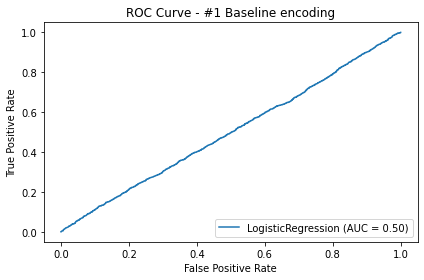

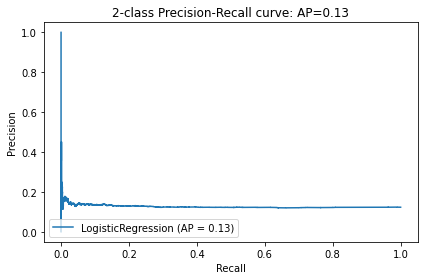

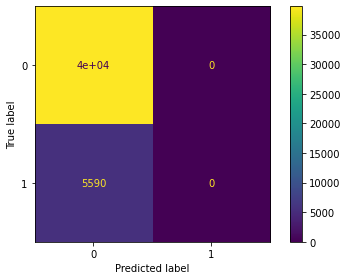

In [27]:
plot_clf_metrics(clf_logst_base_1, '#1 Baseline encoding', X_test, y_test)

####  #2 - Logistic Regression with one-hot encoding (AUC = 0.5)

Let's apply one-hot enconding at the columns: 

- House_Ownership    
- Profession         
- CITY               
- STATE              

After evaluating the baseline model we'll test differents modeling strategies

In [28]:
df_train_wrg_one_hot = pd.get_dummies(df_train_wrg)
print('new dataframe shape:', df_train_wrg_one_hot.shape)

col_target = ['Risk_Flag'] 
splitted_data_dict = split_val_train_test(df_train_wrg_one_hot, col_target)

# Assigning values
X_train, X_test, y_train, y_test = [],[],[],[]
X_train, y_train = splitted_data_dict['X_train'], splitted_data_dict['y_train']
X_test, y_test = splitted_data_dict['X_test'], splitted_data_dict['y_test']
X_val, y_val = splitted_data_dict['X_val'], splitted_data_dict['y_val']

X_train.head()

new dataframe shape: (252000, 408)


,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Is_Single,Has_Car,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented,...,STATE_Punjab,STATE_Rajasthan,STATE_Sikkim,STATE_Tamil_Nadu,STATE_Telangana,STATE_Tripura,STATE_Uttar_Pradesh,STATE_Uttar_Pradesh[5],STATE_Uttarakhand,STATE_West_Bengal
72450,7268991,35,7,7,10,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
195782,5288986,47,3,3,12,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
250365,3954174,33,16,3,14,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
200930,808476,36,1,1,13,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
185020,8845611,37,14,10,13,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


**Logistic regression algorithm**

In [29]:
clf_logst_base_2 = LogisticRegression(random_state=0,
                               class_weight='balanced',
                               max_iter=500)

clf_logst_base_2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=0)

**Evaluating model**

1. AUC ROC -- 0.5
2. AUC PRC -- 0.13
3. Confusion matrix: the model didn't detect any loan default

Our baseline model behaves like a dummy classifier

AUC ROC = 0.5
AUC PRC = 0.13


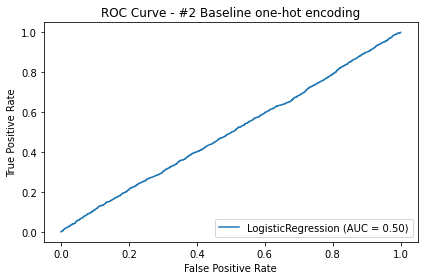

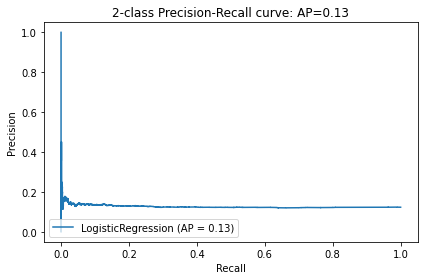

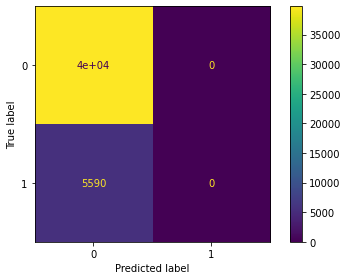

In [30]:
plot_clf_metrics(clf_logst_base_2, '#2 Baseline one-hot encoding', X_test, y_test)

#### #3 - Decision tree categorize encoding (AUC = 0.84) 

Since our first two baseline models weren't good in terms of ROC AUC and PRC AUC, let's try a different algorithm: a simple decision tree with categorize encoding.

Let's categorize the columns: 

- House_Ownership    
- Profession         
- CITY               
- STATE              


**Decision tree regression algorithm**

In [31]:
# Apply categorization
col_target = ['Risk_Flag']
df_categorized_train = prepare_categorized_data(df_train_wrg, cols_to_categorize)

# Splitting data
cols_to_categorize = ['House_Ownership', 'Profession', 'CITY', 'STATE']
splitted_data_dict = split_val_train_test(df_categorized_train, col_target)

# Assigning values
X_train, X_test, y_train, y_test = [],[],[],[]
X_train, y_train = splitted_data_dict['X_train'], splitted_data_dict['y_train']
X_test, y_test = splitted_data_dict['X_test'], splitted_data_dict['y_test']
X_val, y_val = splitted_data_dict['X_val'], splitted_data_dict['y_val']

X_train.head()

,Income,Age,Experience,House_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Is_Single,Has_Car
72450,7268991,35,7,2,48,12,0,7,10,1,1
195782,5288986,47,3,2,12,191,23,3,12,1,0
250365,3954174,33,16,2,22,278,28,3,14,1,0
200930,808476,36,1,2,6,81,10,1,13,1,0
185020,8845611,37,14,2,37,26,22,10,13,1,0


In [32]:
from sklearn.tree import DecisionTreeClassifier

clf_tree_base_3 = DecisionTreeClassifier(random_state=0,
                               class_weight='balanced')

clf_tree_base_3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=0)

**Evaluating model**

1. AUC ROC -- 0.84
2. AUC PRC -- 0.4

This the best model so far!

AUC ROC = 0.84
AUC PRC = 0.4


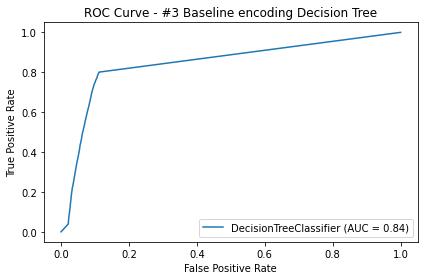

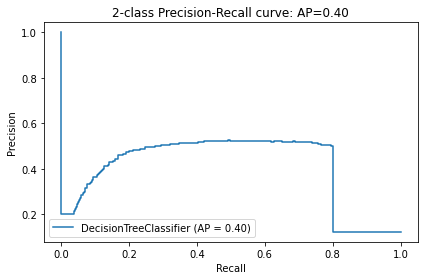

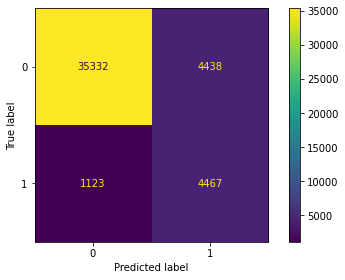

In [33]:
plot_clf_metrics(clf_tree_base_3, '#3 Baseline encoding Decision Tree',
                 X_test, y_test)

---
# Understanding our data

1. Apply a correlation matrix between target and input variables;
2. Apply exploratory data analysis (EDA) driven by hypothesis.

In [34]:
# Applyng basic data cleaning
df_train_wrg = df_train_org.copy()
df_test_wrg = df_test_org.copy()

df_train_wrg = basic_data_cleaning(df_train_wrg)
df_train_wrg = df_train_wrg.drop(columns=['Id'])

# Encoding category columns
df_train_wrg_encoded = df_train_wrg.copy()
cols_to_categorize = ['House_Ownership', 'Profession', 'CITY', 'STATE']

for colname in cols_to_categorize:  
    le = preprocessing.LabelEncoder()
    le.fit(df_train_wrg_encoded[colname])
    df_train_wrg_encoded.loc[:, colname] = le.transform(df_train_wrg_encoded[colname].copy())

---
## Applying a correlation matrix between target and input variables 

- No relevant correlations between target variable and features;
- High correlation between experience and current job years: makes sense because the longer you're in a position more experience you're expected to have;
- We'll need to analyze visually the relationship between the features and risk 

In [35]:
def plot_corr_mtx_pandas(df, method='spearman'):
    corr_mtx = df.corr(method=method)
    return corr_mtx.style.background_gradient(cmap='coolwarm')

In [36]:
corr_mtx = plot_corr_mtx_pandas(df_train_wrg_encoded)
corr_mtx

,Income,Age,Experience,House_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Is_Single,Has_Car
Income,1.000000,-0.000769,0.006387,0.012240,0.000843,-0.001883,-0.004041,0.004253,-0.002450,-0.003082,0.002782,0.004012
Age,-0.000769,1.000000,-0.001063,-0.014262,-0.008637,0.002323,-0.004684,-0.001889,-0.020129,-0.021852,-0.005342,0.009382
Experience,0.006387,-0.001063,1.000000,-0.011094,0.001003,-0.025966,-0.001225,0.643308,0.019240,-0.034443,-0.001748,0.007582
House_Ownership,0.012240,-0.014262,-0.011094,1.000000,0.004434,-0.015640,-0.013319,-0.005583,-0.010074,0.026466,-0.025624,-0.001777
Profession,0.000843,-0.008637,0.001003,0.004434,1.000000,0.018591,0.002232,-0.002883,0.001788,-0.004772,-0.007581,0.011760
CITY,-0.001883,0.002323,-0.025966,-0.015640,0.018591,1.000000,-0.044181,-0.025774,-0.010530,0.004569,0.012351,0.001665
STATE,-0.004041,-0.004684,-0.001225,-0.013319,0.002232,-0.044181,1.000000,0.008564,0.006885,-0.002942,-0.009388,0.025483
CURRENT_JOB_YRS,0.004253,-0.001889,0.643308,-0.005583,-0.002883,-0.025774,0.008564,1.000000,0.004999,-0.018459,0.003987,0.009160
CURRENT_HOUSE_YRS,-0.002450,-0.020129,0.019240,-0.010074,0.001788,-0.010530,0.006885,0.004999,1.000000,-0.004385,-0.007524,0.000315
Risk_Flag,-0.003082,-0.021852,-0.034443,0.026466,-0.004772,0.004569,-0.002942,-0.018459,-0.004385,1.000000,0.021092,-0.024036


In [37]:
# ---- Saving figure for medium text
#plt.subplots(figsize=(8,8))
#plt.title('Correlation between features')
#sns.heatmap(df_train_wrg_encoded.corr(method='spearman').round(2),annot=True)
#plt.tight_layout()
#plt.savefig(img_out_path+'correlation_plot')

---
## Apply exploratory data analysis (EDA) driven by hypothesis

This topic should explore three main aspects of our dataset:

**1. Demography of clients**

   1. Does younger people who have low income have more risk?
   2. Is there any state or city with more loans when analyzing the percentual of risk/population?
    
    
**2. Professional aspects**
    
   1. Professionals with a lower time of experience are more at risk?
   2. Is there a profession or a set of professions more risk?

**3. The inheritance of people who asks for a loan**

   1. People with more patrimony have lower risk? More patrimony is equal to having their car and/or house.

**_Note_**: although I listed the three main aspects of our problem, I'll only make an analysis based on the first one: demography of clients

---
### Demography of clients

1. Does younger people who have low incame are more risk?

**Answer:** No. In some ages people who have **more income** then the samples average are more risk.


2. Is there any state or city with more loans when we analyse the percentual of risk/population?


**Answer:** Yes. There's a risk difference among states. Besides, it is possible to categorize states by default customers with income, low income, and income doesn't make a difference.

In [38]:
cols_demography = ['Age', 'Income', 'CITY', 'STATE', 'Risk_Flag']
df_demography = df_train_org[cols_demography].copy()

df_demography_NO_risk = df_demography.query("Risk_Flag == 0").copy()
df_demography_risk  = df_demography.query("Risk_Flag == 1").copy()

#### **Does younger people who have low incame are more risk?** 

**Answer:** No. In some ages people who have **more income** then the samples average are more risk. Some groups are:

Younger people:
- 21 - 22 years;
- 27 - 28 years;
- 31 years;

Older people:
- 51 and 55 years;
- 60 - 63 years;
- 74 - 79 years;

Other conclusions:
- The average income doens't increase when you get older. Maybe there are more groups that can be determined by region or profession.
- People very young (below 23) and people older (more than 50 years) may be a risk group.
----
**Getting the results**

Before we start the analysis let's plot a boxplot of the variables for check if there'are outliers in our data:

- Age: no outliers
- Income: no outliers

In [39]:
def plot_series_df(df, column):
    pd.DataFrame(df[column]).boxplot()

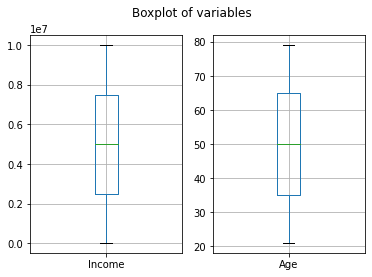

In [40]:
plt.suptitle('Boxplot of variables')

plt.subplot(121)
plot_series_df(df_demography, 'Income')

plt.subplot(122)
plot_series_df(df_demography, 'Age')

In [41]:
df_demography.describe().round(2)

,Age,Income,Risk_Flag
count,252000.00,252000.00,252000.00
mean,49.95,4997116.67,0.12
std,17.06,2878311.01,0.33
min,21.00,10310.00,0.00
25%,35.00,2503015.00,0.00
50%,50.00,5000694.50,0.00
75%,65.00,7477502.00,0.00
max,79.00,9999938.00,1.00


**Plotting**
1. All ages - Average income by age and group;
2. Below 36 years - Average income by age and group;
3. Above 50 years - Average income by age and group;

In [42]:
# Aggregating data 
agg_demography_col = ['Age', 'Income']

agg_df_demography = df_demography[['Age', 'Income', 'Risk_Flag']] \
                            .groupby(['Age', 'Risk_Flag']) \
                            .mean() \
                            .sort_values(by='Age') \
                            .reset_index()

agg_df_demography['Risk_Flag'].replace({0: "No Risk",
                                        1: "Risk"
                                       }, inplace=True)


**_All ages - Average income by age and group_**


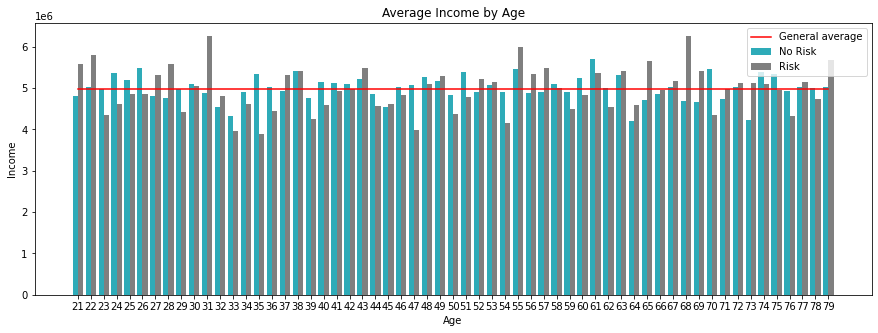

In [43]:
mean_general = df_demography_risk['Income'].mean()
mean_array = mean_general * np.ones(agg_df_demography['Age'].nunique())

palette ={"No Risk": "C9", "Risk": "C7"}

plt.subplots(figsize=(15,5))
sns.barplot(data=agg_df_demography, x='Age', y='Income', hue='Risk_Flag',
           palette=palette)
plt.plot(mean_array, label='General average', color='red')
plt.title('Average Income by Age')
plt.legend(loc='best')
plt.savefig(img_out_path+'avg_income_age')
plt.show()

**_Below 36 years - Average income by age and group_**

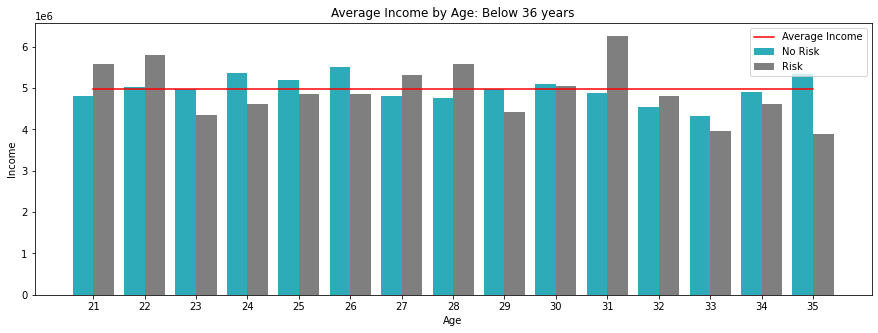

In [44]:
plt.subplots(figsize=(15,5))

sub_set_low_age = agg_df_demography.query("Age <= 35")
sns.barplot(data=sub_set_low_age, x='Age', y='Income', hue='Risk_Flag',
           palette=palette)
plt.plot(mean_array[0:sub_set_low_age['Age'].nunique()],
        label='Average Income', color='red')

plt.title('Average Income by Age: Below 36 years')
plt.legend(loc='best')
plt.savefig(img_out_path+'avg_income_age_below_36')
plt.show()

**_Above 50 years - Average income by age and group_**

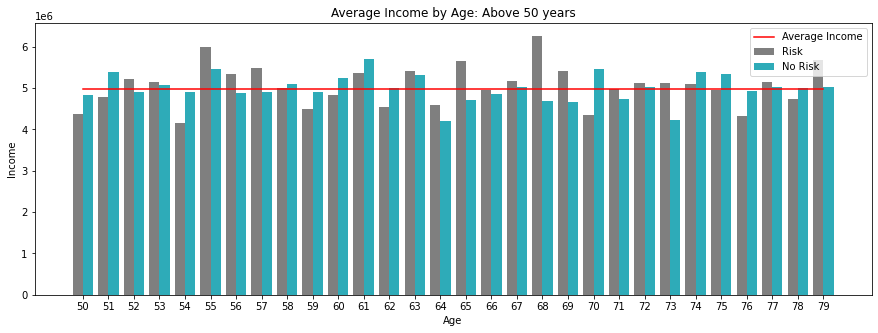

In [45]:
plt.subplots(figsize=(15,5))

sub_set_older_age = agg_df_demography.query("Age >= 50")

sns.barplot(data=sub_set_older_age, x='Age', y='Income',hue='Risk_Flag', 
            palette=palette)

plt.plot(mean_array[0:sub_set_older_age['Age'].nunique()],
        label='Average Income', color='red')

plt.title('Average Income by Age: Above 50 years')
plt.legend(loc='best')
plt.savefig(img_out_path+'avg_income_age_above_50')
plt.show()

---
#### Is there any state or city with more loans when analyzing the percentual of risk/population?


**Answer:** Yes. There's a risk difference among states. Besides, it is possible to categorize states by default customers with income, low income, and income doesn't make a difference.

Other conclusions:
1. States with the **risk associated with high income**: Manipur to Jharkhand, including Puducherry e Himachal_Pradesh;
2. States with the **risk associated with low income**: states like Uttarakhand, Punjab, Chhattisgarh, etc.
3. States were the **risk is not associated with income**: West_Bangal, Tripura, entre outros.

----
**Getting the results**

1. Average income by state;
2. Average risk by state;

In [46]:
cols_geography = ['CITY', 'STATE', 'Risk_Flag']
agg_by_state = df_demography[cols_geography].groupby(['STATE', 'Risk_Flag']) \
                                            .count() \
                                            .reset_index() \
                                            .rename(columns={
                                                        'CITY': '#People'
                                                            })

agg_by_state['Percentage_Total'] = (agg_by_state['#People'] \
                                / agg_by_state['#People'].sum())*100

agg_by_state['Risk_Flag'] = agg_by_state['Risk_Flag'].replace({0:'No Risk',
                                                               1:'Risk'})

In [47]:
cols_geography = ['STATE', 'Risk_Flag', 'Income']

agg_by_state_income = df_demography[cols_geography].groupby(['STATE', 'Risk_Flag']) \
                                            .mean() \
                                            .reset_index() \
                                            .rename(columns={
                                                        'Income': 'Avg Income'
                                                            })

agg_by_state['Avg Income'] = agg_by_state_income['Avg Income']

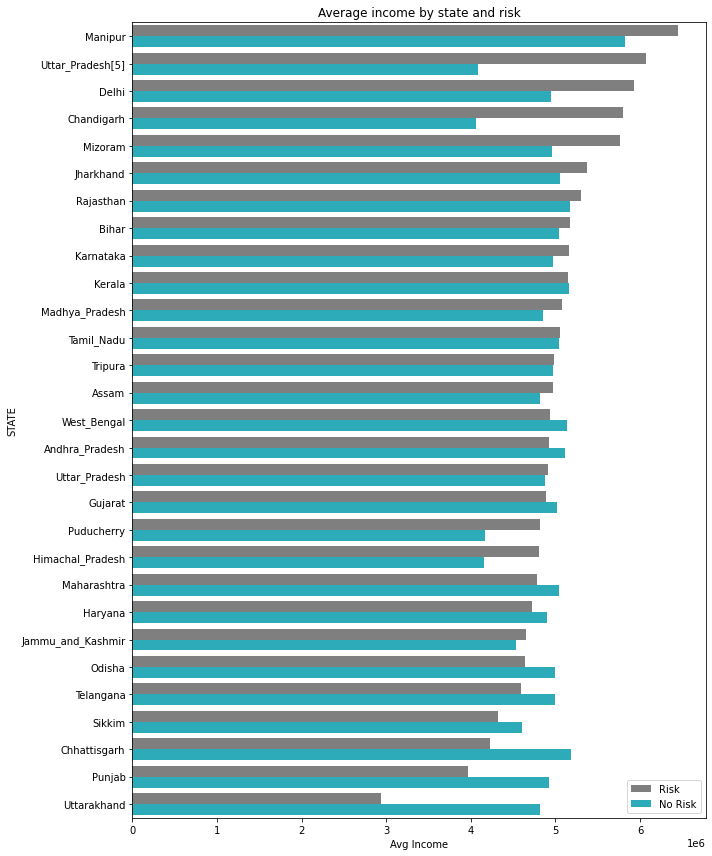

In [48]:
plt.subplots(figsize=(10,12))

agg_by_state = agg_by_state.sort_values(by=['Risk_Flag', 'Avg Income'], ascending=False)

sns.barplot(data=agg_by_state, y='STATE',
            x='Avg Income', hue='Risk_Flag', palette=palette)

#risk_mean = agg_by_state_only_risk['Percentage_Risk'].mean()

#plt.bar(x=risk_mean, height = len(agg_by_state_only_risk), width=0.1,
#        label='Average Risk by state', color='red')

plt.title('Average income by state and risk')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(img_out_path+'avg_income_state')
plt.show()

In [49]:
# Count number of clients in each state
state_count = df_demography['STATE'].value_counts().sort_index()

# Aggregate data to get proportion of risk operations in each state
agg_by_state_only_risk = agg_by_state.query("Risk_Flag == 'Risk'").copy()
agg_by_state_only_risk = agg_by_state_only_risk.sort_values(by=['STATE'])

agg_by_state_only_risk['#People_State'] = state_count.values

agg_by_state_only_risk['Percentage_Risk'] = (agg_by_state_only_risk['#People'].values \
                                            / state_count.values) * 100
                
agg_by_state_only_risk = agg_by_state_only_risk.sort_values(
                                                by=['Percentage_Risk'],
                                                ascending=False)

In [50]:
agg_by_state_only_risk.head()

,STATE,Risk_Flag,#People,Percentage_Total,Avg Income,#People_State,Percentage_Risk
31,Manipur,Risk,183,0.072619,6.452880e+06,849,21.554770
49,Tripura,Risk,136,0.053968,4.984898e+06,809,16.810878
25,Kerala,Risk,970,0.384921,5.148648e+06,5805,16.709733
19,Jammu_and_Kashmir,Risk,283,0.112302,4.656932e+06,1780,15.898876
27,Madhya_Pradesh,Risk,2180,0.865079,5.075821e+06,14122,15.436907


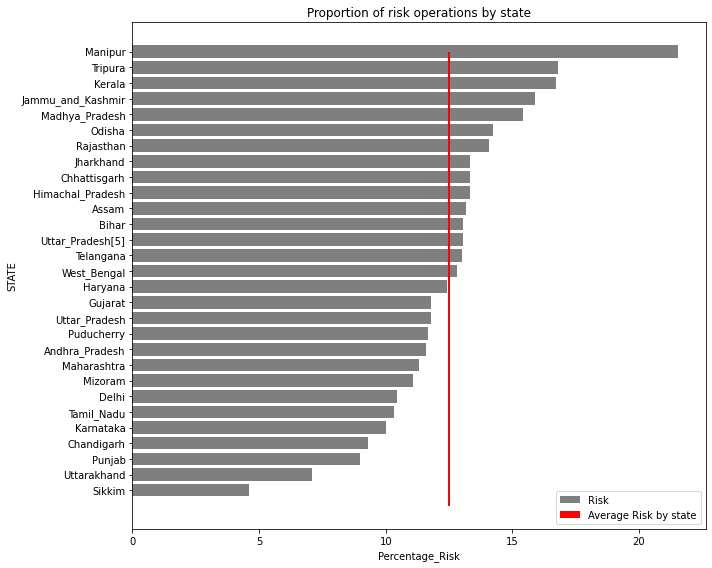

In [51]:
plt.subplots(figsize=(10,8))

sns.barplot(data=agg_by_state_only_risk, y='STATE',
            x='Percentage_Risk', hue='Risk_Flag',palette=palette)

risk_mean = agg_by_state_only_risk['Percentage_Risk'].mean()

plt.bar(x=risk_mean, height = len(agg_by_state_only_risk), width=0.1,
        label='Average Risk by state', color='red')

plt.title('Proportion of risk operations by state')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(img_out_path+'risk_state')
plt.show()

---
# Improving our solution

1. Train two new models and compare with our baseline;
2. Select the best model;
3. Next steps for our solution;

## Train two new models and compare with our baseline

We'll compare this algorithms:

1. Random Forest;
2. SVM;
3. Decision Tree (baseline).

**Prepare data for training**

In [52]:
## Basic data cleaning
df_train_wrg = df_train_org.copy()
df_train_wrg = basic_data_cleaning(df_train_wrg)
df_train_wrg = df_train_wrg.drop(columns=['Id'])

# Apply categorization
col_target = ['Risk_Flag']
df_categorized_train = prepare_categorized_data(df_train_wrg, cols_to_categorize)

# Splitting data
cols_to_categorize = ['House_Ownership', 'Profession', 'CITY', 'STATE']
splitted_data_dict = split_val_train_test(df_categorized_train, col_target)

# Assigning values
X_train, X_test, y_train, y_test = [],[],[],[]
X_train, y_train = splitted_data_dict['X_train'], splitted_data_dict['y_train']
X_test, y_test = splitted_data_dict['X_test'], splitted_data_dict['y_test']
X_val, y_val = splitted_data_dict['X_val'], splitted_data_dict['y_val']

### Random Forest

In [53]:
# Classifier
clf_rdn_forest_1 = RandomForestClassifier(class_weight='balanced',
                                          n_estimators=300,
                                          random_state=0,
                                          verbose=1)

# Training
clf_rdn_forest_1.fit(X_train, y_train)

# Predict probability
y_pred_rdn_forest_1 = clf_rdn_forest_1.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    6.5s finished


### SVM

In [54]:
# Classifier
clf_svm_1 = make_pipeline(StandardScaler(), SVC(gamma='auto',
                                                class_weight='balanced',
                                                probability=True,
                                                verbose=1,
                                                max_iter=200))
# Training
clf_svm_1.fit(X_train, y_train)

# Predict probability
y_pred_svm_1 = clf_svm_1.predict_proba(X_test)[:, 1]

[LibSVM]

C:\Users\herna\anaconda3\envs\gamma\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


## Select the best model

- Best model: Random forest (ROC AUC =  0.94 and PR AUC = 0.59)
- Sugested threshold:

### Evaluating models

In [55]:
def plot_roc_curve_multiple_classifiers(X_test, y_true, clf_list,
                                        clf_names, class_num=1):
    for i, clf in enumerate(clf_list):
        pred = clf.predict_proba(X_test)[:, class_num]
        fpr, tpr, thresh = metrics.roc_curve(y_true, pred)
        auc = metrics.roc_auc_score(y_true, pred)
        label_plot = clf_names[i] + ' auc=' +str(auc.round(2))
        plt.plot(fpr,tpr,label=label_plot)
        plt.legend(loc='best')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.savefig(img_out_path+'roc_curve_comparison')

In [56]:
def plot_precision_recall_curve_multiple_classifiers(X_test, y_true,
                                                     clf_list,
                                                     clf_names,
                                                     class_num=1):
    for i, clf in enumerate(clf_list):
        pred = clf.predict_proba(X_test)[:, class_num]
        precision, recall, thresholds = metrics.precision_recall_curve(y_true, pred)
        auc = metrics.average_precision_score(y_true, pred)
        
        label_plot = clf_names[i] + ' auc=' +str(auc.round(2))
        plt.plot(recall,precision,label=label_plot)
        plt.legend(loc='best')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.savefig(img_out_path+'prc_curve_comparison')

In [57]:
def plot_multiple_model_evaluation(X_test, y_true,
                                   clf_list, clf_names, class_num=1):

    plt.subplots(figsize=(15, 4))

    plt.subplot(121)
    plt.title('ROC Curve')
    plot_roc_curve_multiple_classifiers(X_test, y_test, clf_list, clf_names)

    plt.subplot(122)
    plt.title('Precision Recall Curve')
    plot_precision_recall_curve_multiple_classifiers(X_test, y_test, clf_list, clf_names)
    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    7.2s finished


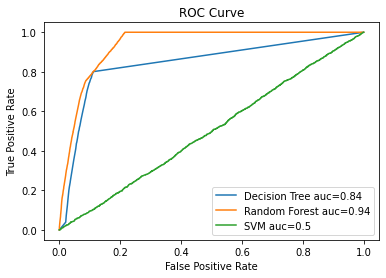

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    7.0s finished


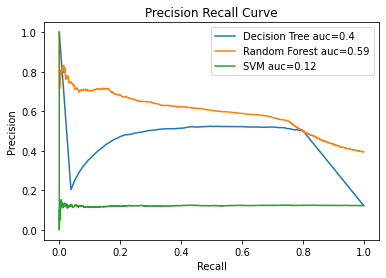

In [58]:
# Saving fig
clf_names = ['Decision Tree', 'Random Forest', 'SVM']
clf_list = [clf_tree_base_3, clf_rdn_forest_1, clf_svm_1]
plt.title('ROC Curve')
plot_roc_curve_multiple_classifiers(X_test, y_test, clf_list, clf_names)
plt.show()
plt.title('Precision Recall Curve')
plot_precision_recall_curve_multiple_classifiers(X_test, y_test, clf_list, clf_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    7.4s finished


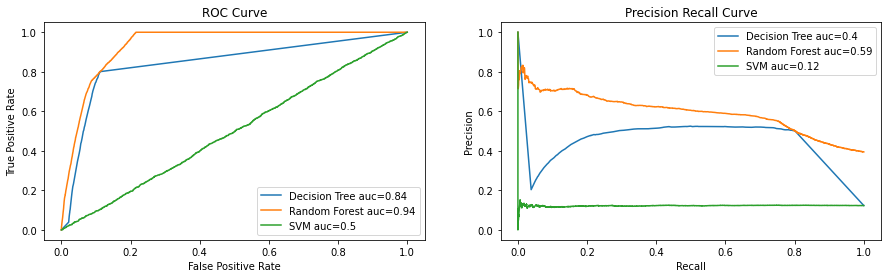

In [59]:
clf_names = ['Decision Tree', 'Random Forest', 'SVM']
clf_list = [clf_tree_base_3, clf_rdn_forest_1, clf_svm_1]
plot_multiple_model_evaluation(X_test, y_test, clf_list, clf_names)
plt.savefig(img_out_path+'model_curves')

### Evaluating the Random Forest model on Validation data

Analysing the result in the validation dataset with a prediction threshold of 85%



In [60]:
threshold_prediction = 0.85

# Predicting validation data
y_pred_val = clf_rdn_forest_1.predict_proba(X_val)[:, 1]
val_classif = (y_pred_val >= threshold_prediction).astype(int)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.2s finished


In [61]:
tn, fp, fn, tp = metrics.confusion_matrix(y_val, val_classif).ravel()
val_conf_mtx = pd.DataFrame([[tp, fp], [fn, tn]],
                            index=['Pred: Risk', 'Pre: NO Risk'],
                            columns=['True: Risk','True: No Risk'])

val_conf_mtx

,True: Risk,True: No Risk
Pred: Risk,1930,1331
Pre: NO Risk,1209,20730


---
## Next steps for our solution

To improve our solution, we could:

**Optimize our current model**
- Find new hyperparameters that improve the roc AUC metric;

**Explore our data and have new insights**
- Explore the other bucket's of our problem: patrimony and professions;
- Apply clustering techniques and find the different types of risk operations.

**Create a new model**
- Use the findings in the last topic to create new features for the model and try different algorithms comparing them with the current solution.